# Image Colorization


In this notebook I base myself on the [Deep Koalarization: Image Colorization usingCNNs and Inception-Resnet-v2](https://arxiv.org/pdf/1712.03400.pdf) paper to implement a neural network to colorize black and white images.

To train, test and validate this network I use the ILSVRC2017 dataset.

To run on TPU:

```
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)
```

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.3.0


When I tried running everything on TPU, when training the model, I got an `Unavailable: {{function_node __inference_train_function_243071}} failed to connect to all addresses`. So I am running the notebook on GPU instead.

To run on GPU:  (When TPU is unavailable)

In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


### Opening and reading images

To upload a local file :
```
from google.colab import files
files.upload()
```
Or simply upload it to the drive and mount it.

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
%%capture
!tar -xvf /content/drive/MyDrive/'Colab Notebooks'/data.tar.gz

In [5]:
!ls data/train/imgs | wc -l
!ls data/validate/imgs | wc -l

4901
499


In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

from skimage.io import imread
from skimage.color import rgb2lab, lab2rgb

sample image shape:  (375, 500, 3)


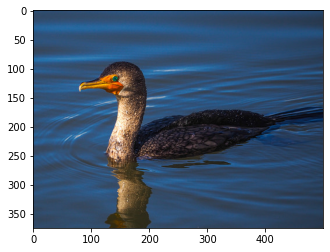

In [7]:
sample_image_name = !ls data/train/imgs | head -n 1
sample_image = imread("data/train/imgs/{}".format(sample_image_name[0]))

size = sample_image.shape
print("sample image shape: ", sample_image.shape)

plt.imshow(sample_image.astype('uint8'));

### The Lab color space

In the [paper](https://arxiv.org/pdf/1712.03400.pdf) I'm basing myself on, the researchers assume there's a mapping $\mathcal{F}$ such as $\mathcal{F} : X_L \longrightarrow (\tilde X_a, \tilde X_b)$, where $X_L$ is the luminance component or greyscale image and $\tilde X_a$ and $\tilde X_b$ are the $a$, $b$ components of the reconstructed image, which combined with the input give the estimated colored image $\tilde X = (X_L, \tilde X_a, \tilde X_b)$. 

And thus we consider images in the $Lab$ colorspace where $L$ is the luminance, $a$ is the green-red color spectrum and $b$ is the blue-yellow color spectrum.

In [8]:
# Image values have to be between 0 and 1 for the Lab conversion to work.
sample_image_lab = rgb2lab(sample_image/255.0)

In [9]:
# Extracting each Lab channel and converting it to RGB for display.
def extract_lab_chan(img, dim):
    x = np.zeros(img.shape)
    if dim != 0:
        x[:, :, 0] = 80  # necessary so for minimal brightness.
    x[:, :, dim] = img[:, :, dim]
    return lab2rgb(x)

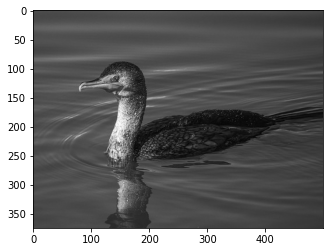

In [10]:
plt.imshow(extract_lab_chan(sample_image_lab, 0));  # L channel

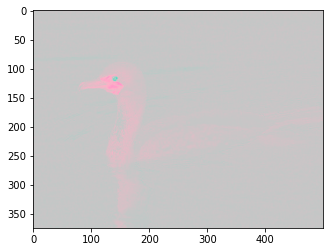

In [11]:
plt.imshow(extract_lab_chan(sample_image_lab, 1));  # green-red channel

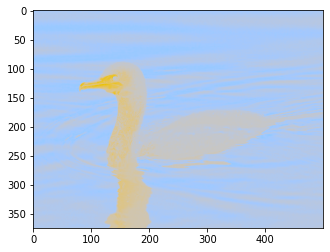

In [12]:
plt.imshow(extract_lab_chan(sample_image_lab, 2));  # blue-yellow

### Loading Inception ResNet v2

In [13]:
from tensorflow.keras.applications import InceptionResNetV2

In [14]:
inception = InceptionResNetV2(weights="imagenet", include_top=True)
# inception.load_weights("data/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5")

### Encoder

In [15]:
from tensorflow.keras.layers import Input, Conv2D

In [16]:
encoder_input = Input(shape=(224, 224, 1,))
encoder_output = Conv2D(64, (3, 3), strides=(2, 2), padding="same", activation="relu")(encoder_input)
encoder_output = Conv2D(128, (3, 3), strides=(1, 1), padding="same", activation="relu")(encoder_output)
encoder_output = Conv2D(128, (3, 3), strides=(2, 2), padding="same", activation="relu")(encoder_output)
encoder_output = Conv2D(256, (3, 3), strides=(1, 1), padding="same", activation="relu")(encoder_output)
encoder_output = Conv2D(256, (3, 3), strides=(2, 2), padding="same", activation="relu")(encoder_output)
encoder_output = Conv2D(512, (3, 3), strides=(1, 1), padding="same", activation="relu")(encoder_output)
encoder_output = Conv2D(512, (3, 3), strides=(1, 1), padding="same", activation="relu")(encoder_output)
encoder_output = Conv2D(256, (3, 3), strides=(1, 1), padding="same", activation="relu")(encoder_output)

### Fusion

In [17]:
from tensorflow.keras.layers import RepeatVector, Reshape, concatenate

In [18]:
fusion_input = Input(shape=(1000,))
fusion_output = RepeatVector(28 * 28)(fusion_input)  # HW/8**2
fusion_output = Reshape(([28, 28, 1000]))(fusion_output)
fusion_output = concatenate([encoder_output, fusion_output], axis=3) 
fusion_output = Conv2D(256, (1, 1), strides=(1, 1), padding="same", activation="relu")(fusion_output)

### Decoder

In [19]:
from tensorflow.keras.layers import UpSampling2D

In [20]:
decoder_output = Conv2D(128, (3, 3), strides=(1, 1), padding="same", activation="relu")(fusion_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)  # Upsampling to twice the size of the input.
decoder_output = Conv2D(64, (3, 3), strides=(1, 1), padding="same", activation="relu")(decoder_output)
decoder_output = Conv2D(64, (3, 3), strides=(1, 1), padding="same", activation="relu")(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(32, (3, 3), strides=(1, 1), padding="same", activation="relu")(decoder_output)
decoder_output = Conv2D(2, (3, 3), strides=(1, 1), padding="same", activation="tanh")(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)

### Model

In [21]:
from tensorflow.keras.models import Model

In [22]:
model = Model(inputs=[encoder_input, fusion_input], outputs=decoder_output)

### Data

In [23]:
from skimage.transform import resize
from skimage.color import gray2rgb, rgb2gray

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img

Creating inception embedding by resizing images to suit inception input size and predicting on said input.

In [24]:
def inception_embedding(grayscaled_rgb_imgs):
  resized = []
  for img in grayscaled_rgb_imgs:
    resized.append(resize(img, (299, 299, 3), mode="constant"))
  inception_output = inception.predict(preprocess_input(np.array(resized)))
  return inception_output

Preprocessing function to scale images to fall in the 0-1 range:

In [25]:
def preprocess_image(img):
  img = img_to_array(img) / 255.0 
  return np.array(img)

In [26]:
datagen = ImageDataGenerator(
        shear_range=0.4,
        zoom_range=0.4,
        rotation_range=40,
        horizontal_flip=True,
        preprocessing_function=preprocess_image)

In [27]:
batch_size = 32
batch_size

32

In [28]:
def img_gen(batch_size, path="data/train/"):
  for batch in datagen.flow_from_directory(path, target_size=(224, 224), batch_size=batch_size, class_mode=None):
    grayscaled_rgb_imgs = gray2rgb(rgb2gray(batch))   # We get gray images in the RGB color scope.
    batch_lab = rgb2lab(batch)
    grayscaled_rgb_imgs = np.array(grayscaled_rgb_imgs)
    batch_lab = np.array(batch_lab)
    X_batch = batch_lab[:, :, :, 0]  # first channel of every image in the batch. Resulting shape is (batch_size, 224, 224)
    # Adding a dimension: X_batch shape will be (batch_size, 224, 224, 1).
    # This is necessary because the first convolution layer expects a shape of (224, 224, 1)
    X_batch = X_batch.reshape(X_batch.shape + (1, ))
    Y_batch = batch_lab[:,:,:,1:] / 128  # Lab scope is bounded by 128
    yield ([np.array(X_batch), np.array(inception_embedding(grayscaled_rgb_imgs))], np.array(Y_batch))

### Training

In [29]:
from tensorflow.keras.optimizers import Adam

In [30]:
model.compile(optimizer=Adam(lr=0.001), loss='mse')  # mean square error is the loss used in the paper.
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
conv2d_203 (Conv2D)             (None, 112, 112, 64) 640         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_204 (Conv2D)             (None, 112, 112, 128 73856       conv2d_203[0][0]                 
__________________________________________________________________________________________________
conv2d_205 (Conv2D)             (None, 56, 56, 128)  147584      conv2d_204[0][0]                 
_______________________________________________________________________________________

Setting a EasyStop callback, which will stop training after the loss hasn't decreased for 3 consecutive epochs.

In [31]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4)

Preparing validation data: (We don't have too much data so no need to use an ImageDataGenerator)

In [32]:
imgs = []

for filename in os.listdir("data/validate/imgs/"):
  imgs.append(resize(img_to_array(load_img("data/validate/imgs/" + filename)), (224, 224, 3), mode="constant"))

imgs = np.array(imgs, dtype=float) / 255.0
grayscaled_rgb_imgs = gray2rgb(rgb2gray(imgs))   # We get gray images in the RGB color scope.
imgs_lab = rgb2lab(imgs)
grayscaled_rgb_imgs = np.array(grayscaled_rgb_imgs)
X_val = imgs_lab[:, :, :, 0]
X_val = X_val.reshape(X_val.shape + (1, ))
Y_val = imgs_lab[:,:,:,1:] / 128  # Lab scope is bounded by 128
X_val_inception = np.array(inception_embedding(grayscaled_rgb_imgs))

In [33]:
model.fit(
    img_gen(batch_size),
    validation_data=([X_val, X_val_inception], Y_val),
    epochs=10,
    callbacks=[callback],
    steps_per_epoch=32)

Found 4901 images belonging to 1 classes.
Epoch 1/10
32/32 [==============================] - 51s 2s/step - loss: 0.0453 - val_loss: 0.0134
Epoch 2/10
32/32 [==============================] - 50s 2s/step - loss: 0.0143 - val_loss: 0.0135
Epoch 3/10
32/32 [==============================] - 50s 2s/step - loss: 0.0143 - val_loss: 0.0134
Epoch 4/10
32/32 [==============================] - 50s 2s/step - loss: 0.0146 - val_loss: 0.0135
Epoch 5/10
32/32 [==============================] - 50s 2s/step - loss: 0.0142 - val_loss: 0.0135
Epoch 6/10
32/32 [==============================] - 50s 2s/step - loss: 0.0144 - val_loss: 0.0134
Epoch 7/10
32/32 [==============================] - 50s 2s/step - loss: 0.0144 - val_loss: 0.0135
Epoch 8/10
32/32 [==============================] - 50s 2s/step - loss: 0.0137 - val_loss: 0.0135
Epoch 9/10
32/32 [==============================] - 50s 2s/step - loss: 0.0136 - val_loss: 0.0135
Epoch 10/10
32/32 [==============================] - 49s 2s/step - loss: 0.0

### Testing

Preparing Test dataset

In [34]:
grayscale_imgs = []
for filename in os.listdir("data/test/imgs"):
  grayscale_imgs.append(resize(img_to_array(load_img("data/test/imgs/" + filename)), (224, 224, 3), mode="constant"))

grayscale_imgs = np.array(grayscale_imgs, dtype=float) / 255.0
grayscale_imgs = gray2rgb(rgb2gray(grayscale_imgs))
grayscale_imgs_inception = inception_embedding(grayscale_imgs)
grayscale_imgs = rgb2lab(grayscale_imgs)[:,:,:,0]
grayscale_imgs = grayscale_imgs.reshape(grayscale_imgs.shape + (1, ))

Predicting on test dataset:

In [35]:
results = model.predict([grayscale_imgs, grayscale_imgs_inception])
results *= 128

In [36]:
results.argmax()

2381581

Saving test results:

In [37]:
if not os.path.exists("results"):
    os.mkdir("results")
  
for i in range(len(results)):
  img = np.zeros((224, 224, 3))
  img[:,:,0] = grayscale_imgs[i][:,:,0]
  img[:,:,1:] = results[i]
  plt.imsave("results/img_" + str(i) + ".png", lab2rgb(img))

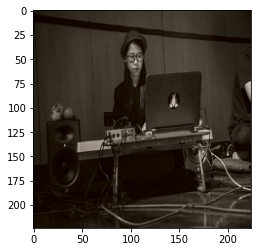

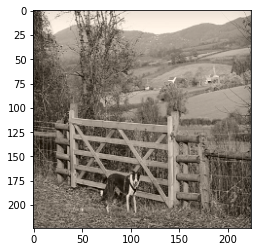

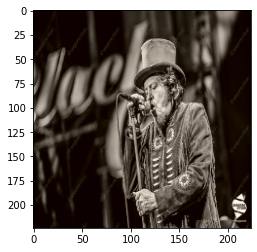

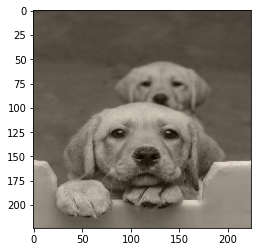

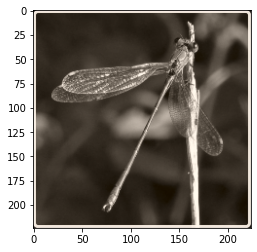

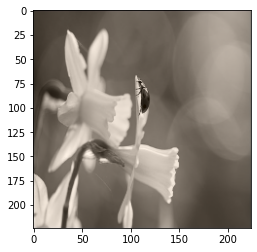

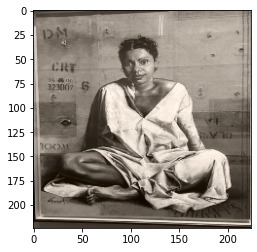

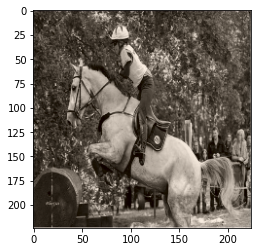

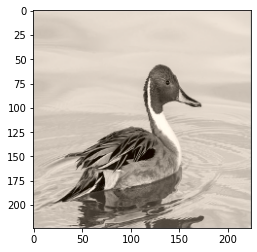

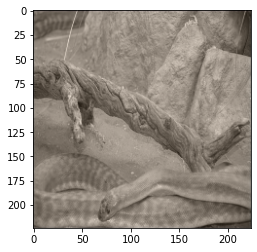

In [38]:
some_results = !ls results/ | tail -n 10

for i in some_results:
  plt.figure()
  plt.imshow(img_to_array(load_img("results/" + i)).astype('uint8'))

The model seems to be producing images in a brownish shade.
A next step would be to train on another dataset and see how the results would differ.
It could be an issue of size. The dataset I use to train the model has 4901 images and with so few images the model could be not learning well or enough. With RAM, GPU and time constraints, larger datasets remain out of my reach. 